In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import math
import glob
import scipy.signal as signal, scipy.ndimage as ndimage
from pathlib import Path

In [2]:
def smooth_savgol_octave(freq, spl, fraction=1/24):
    """
    Smoothing using Savitzky-Golay filter in log frequency domain
    """
    # Sort by frequency (important for proper filtering)
    sort_idx = np.argsort(freq)
    freq_sorted = freq[sort_idx]
    spl_sorted = spl[sort_idx]
    
    # Convert to log frequency
    log_freq = np.log10(freq_sorted)
    
    # Calculate window length based on data density and octave fraction
    log_freq_range = log_freq.max() - log_freq.min()
    points_per_octave = len(log_freq) / log_freq_range
    window_points = max(5, int(points_per_octave * fraction))
    if window_points % 2 == 0:
        window_points += 1
    
    # Apply Savitzky-Golay filter
    smoothed_spl = signal.savgol_filter(spl_sorted, window_points, 3)
    
    # Return original order
    result = np.zeros_like(spl_sorted)
    result[sort_idx] = smoothed_spl
    
    return freq, result

def compute_impulse_response(freq, spl_db, phase_deg, sample_rate=48000, n_fft=8192):
    """
    Compute impulse response from frequency domain data
    
    Parameters:
    - freq: frequency array (Hz)
    - spl_db: magnitude response in dB
    - phase_deg: phase response in degrees
    - sample_rate: sample rate for time axis
    - n_fft: FFT size for inverse transform
    """
    # Convert dB to linear magnitude
    magnitude = 10 ** (spl_db / 20.0)
    
    # Convert phase to radians
    phase_rad = np.deg2rad(phase_deg)
    
    # Create complex frequency response
    complex_response = magnitude * np.exp(1j * phase_rad)
    
    # Interpolate to uniform frequency grid for IFFT
    freq_uniform = np.linspace(0, sample_rate/2, n_fft//2 + 1)
    magnitude_interp = np.interp(freq_uniform, freq, magnitude, left=0, right=0)
    phase_interp = np.interp(freq_uniform, freq, phase_rad, left=0, right=0)
    complex_uniform = magnitude_interp * np.exp(1j * phase_interp)
    
    # Create full spectrum (conjugate symmetric for real signal)
    full_spectrum = np.zeros(n_fft, dtype=complex)
    full_spectrum[0:n_fft//2+1] = complex_uniform
    full_spectrum[n_fft//2+1:] = np.conj(complex_uniform[1:-1][::-1])
    
    # Inverse FFT
    impulse = np.fft.ifft(full_spectrum).real
    
    # Time axis in milliseconds
    time_ms = np.arange(n_fft) / sample_rate * 1000
    
    return time_ms, impulse

def compute_group_delay(freq, phase_deg):
    """
    Compute group delay from phase response
    
    Group delay = -dφ/dω where φ is phase in radians, ω is angular frequency
    
    Parameters:
    - freq: frequency array (Hz)
    - phase_deg: phase response in degrees
    
    Returns:
    - freq: frequency array (Hz)
    - group_delay: group delay in milliseconds
    """
    # Convert to radians and unwrap phase
    phase_rad = np.deg2rad(phase_deg)
    phase_unwrapped = np.unwrap(phase_rad)
    
    # Angular frequency: ω = 2πf
    omega = 2 * np.pi * freq
    
    # Compute derivative using central differences
    # group_delay = -dφ/dω
    d_phase = np.gradient(phase_unwrapped)
    d_omega = np.gradient(omega)
    
    group_delay_sec = -d_phase / d_omega
    group_delay_ms = group_delay_sec * 1000  # Convert to milliseconds
    
    return freq, group_delay_ms

In [3]:
colors = px.colors.qualitative.Set1

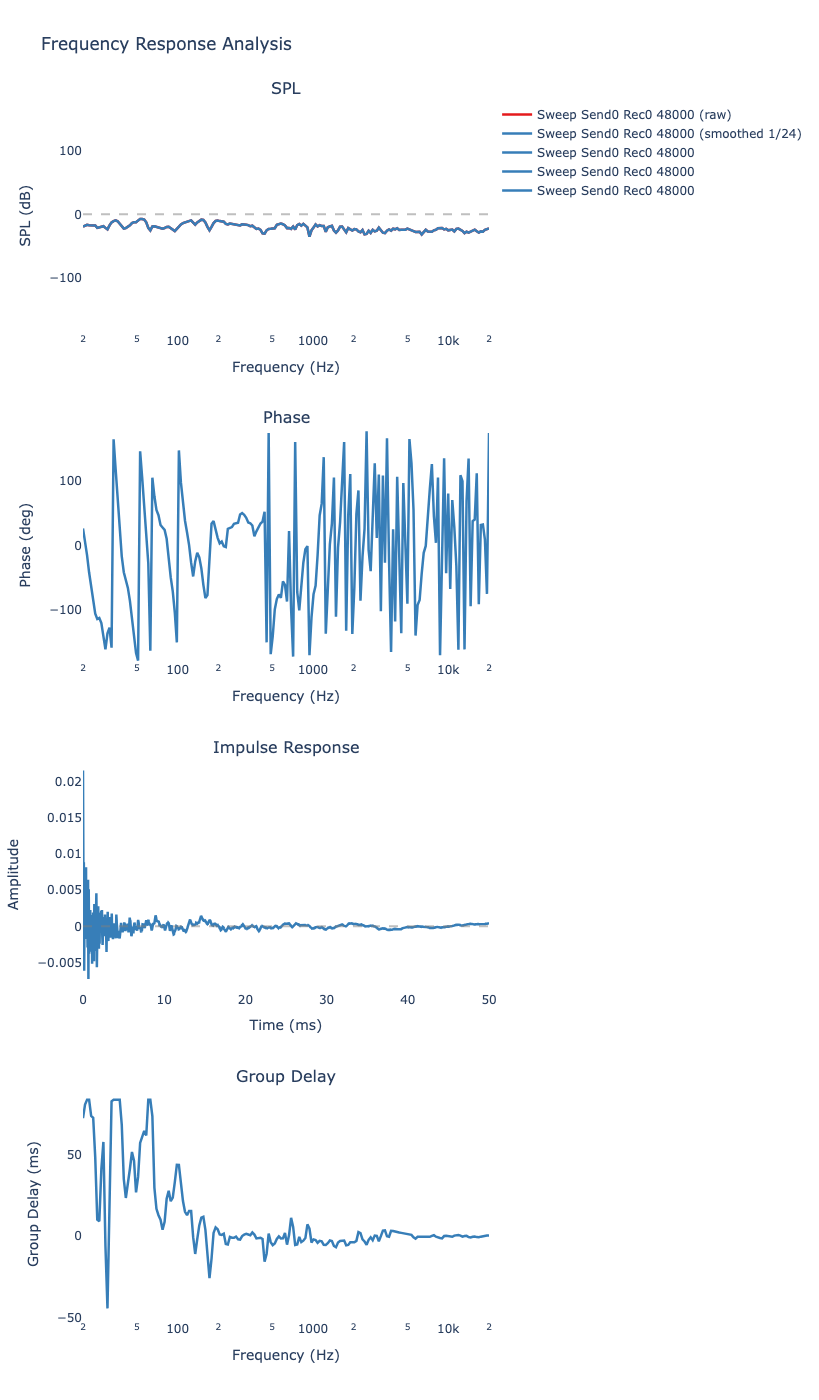

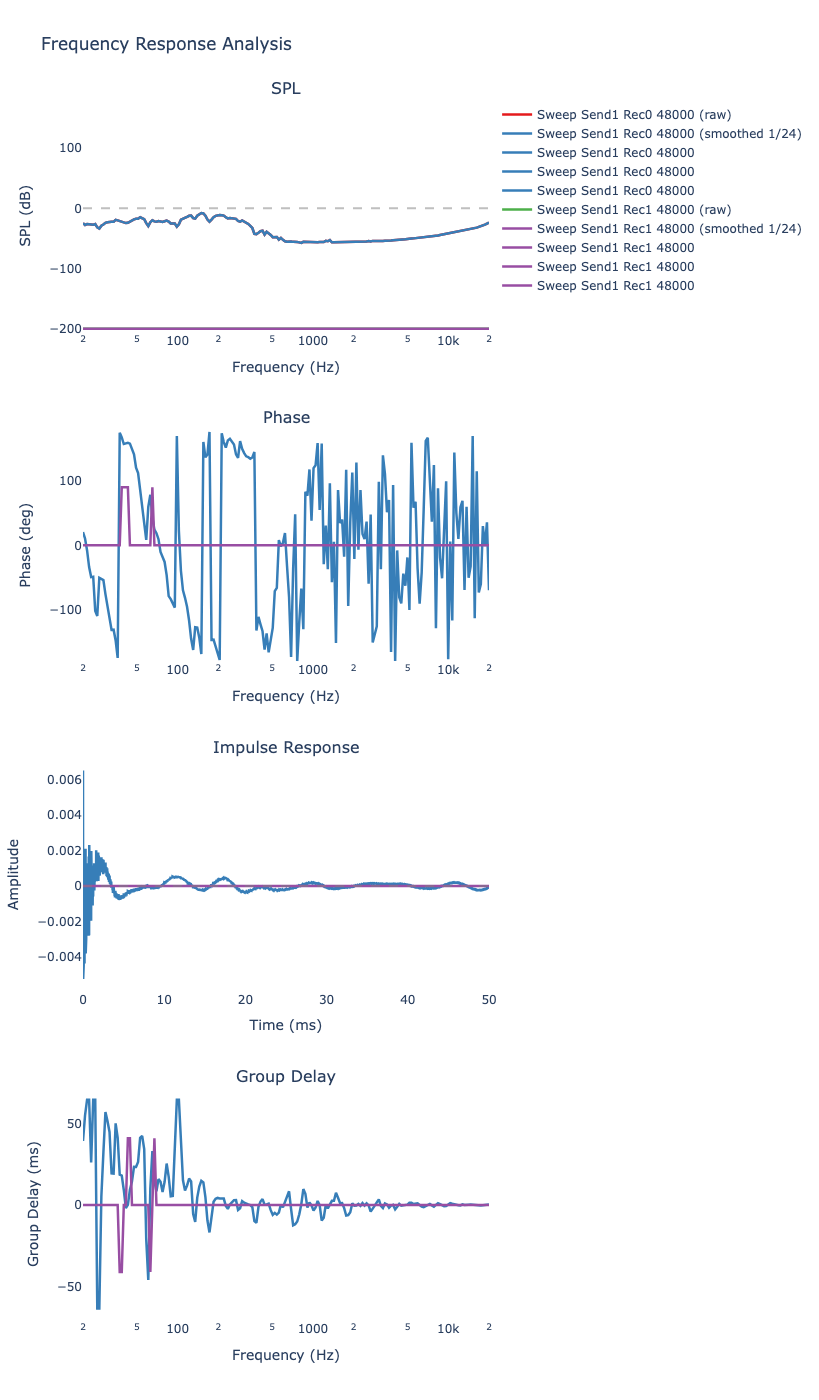

In [9]:
icolor = 0
fig = {}
for i, csv_file in enumerate(sorted(glob.glob("*.csv"))):
    try:
        channel = csv_file[10:11]
        if channel not in fig:
            icolor = 0
            fig[channel] = make_subplots(
                rows=4, 
                cols=1, 
                subplot_titles=('SPL', 'Phase', 'Impulse Response', 'Group Delay'),
                specs=[
                    [{"secondary_y": False}], 
                    [{"secondary_y": False}],
                    [{"secondary_y": False}],
                    [{"secondary_y": False}]
                ],
                vertical_spacing=0.08
            )
        else:
            icolor += 1
        df = pd.read_csv(csv_file)
        if 'frequency_hz' not in df.columns or 'spl_db' not in df.columns:
            continue
        # Extract and clean data
        freq = df['frequency_hz'].values
        spl = df['spl_db'].values
        phase = df['phase_deg'].values
        valid = np.isfinite(freq) & np.isfinite(spl) & np.isfinite(phase)
        freq, spl, phase = freq[valid], spl[valid], phase[valid]
        
        # Apply smoothing
        octave = 24
        smoothed_freq, smoothed_spl = freq, spl # smooth_savgol_octave(freq, spl, 1.0/octave)
        
        # Compute impulse response
        time_ms, impulse = compute_impulse_response(freq, spl, phase)
        
        # Compute group delay
        gd_freq, group_delay = compute_group_delay(freq, phase)
        
        # Create nice name
        name = Path(csv_file).stem.replace('_', ' ').title()
        
        # Add SPL plot
        fig[channel].add_trace(go.Scatter(
            x=freq, 
            y=spl, 
            name='{} (raw)'.format(name), 
            line=dict(color=colors[icolor % len(colors)], width=2.5),
        ), row=1, col=1)
        icolor += 1
        fig[channel].add_trace(go.Scatter(
            x=smoothed_freq, 
            y=smoothed_spl, 
            name='{} (smoothed 1/{})'.format(name, octave), 
            line=dict(color=colors[icolor % len(colors)], width=2.5),
        ), row=1, col=1)
        
        # Add Phase plot
        fig[channel].add_trace(go.Scatter(
            x=freq, 
            y=phase, 
            name=name,
            line=dict(color=colors[icolor % len(colors)], width=2.5),
        ), row=2, col=1)
        
        # Add Impulse Response plot (show first 50ms)
        time_window = time_ms <= 50
        fig[channel].add_trace(go.Scatter(
            x=time_ms[time_window], 
            y=impulse[time_window], 
            name=name,
            line=dict(color=colors[icolor % len(colors)], width=2.5),
        ), row=3, col=1)
        
        # Add Group Delay plot
        # Filter out extreme values for better visualization
        gd_median = np.median(group_delay)
        gd_std = np.std(group_delay)
        gd_filtered = np.clip(group_delay, gd_median - 3*gd_std, gd_median + 3*gd_std)
        
        fig[channel].add_trace(go.Scatter(
            x=gd_freq, 
            y=gd_filtered, 
            name=name,
            line=dict(color=colors[icolor % len(colors)], width=2.5),
        ), row=4, col=1)

    except Exception as e:
        print(f"✗ {csv_file}: {e}")

for f in fig.values():   
    min_spl = 1000
    max_spl = -1000
    for t in f.data:
        if hasattr(t, 'y'):
            min_spl = min(min_spl, np.min(t.y))
            max_spl = max(max_spl, np.max(t.y))
    max_spl = 5*(int(max_spl) // 5)+5
    min_spl = 5*(int(min_spl) // 5)-5
    
    # Add reference lines
    f.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5, row=1, col=1)
    f.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5, row=3, col=1)
    
    # Update layout
    f.update_xaxes(title_text="Frequency (Hz)", type="log", range=[1+math.log10(2), 4+math.log10(2)], row=1, col=1)
    f.update_xaxes(title_text="Frequency (Hz)", type="log", range=[1+math.log10(2), 4+math.log10(2)], row=2, col=1)
    f.update_xaxes(title_text="Time (ms)", row=3, col=1)
    f.update_xaxes(title_text="Frequency (Hz)", type="log", range=[1+math.log10(2), 4+math.log10(2)], row=4, col=1)
    
    f.update_yaxes(title_text="SPL (dB)", range=[min_spl, max_spl], row=1, col=1)
    f.update_yaxes(title_text="Phase (deg)", range=[-180, 180], row=2, col=1)
    f.update_yaxes(title_text="Amplitude", row=3, col=1)
    f.update_yaxes(title_text="Group Delay (ms)", row=4, col=1)
    
    f.update_layout(
        title='Frequency Response Analysis',
        height=1400,
        showlegend=True,
        plot_bgcolor='white'
    )
    f.show()
    